In [2]:
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dropout, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import backend as K 
from tensorflow.python.client import device_lib

import os
import matplotlib.pyplot as plt

from IAdeforestation.training import *

Using TensorFlow backend.


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13902694377511683611
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3172404430
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14153143292671110272
physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


In [3]:
#initial_model = load_model("transfer_learning_model/dense_RGB_from_scratch.313-0.978.hdf5", compile=False)
initial_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)

initial_model = Model(inputs=initial_model.input, outputs=initial_model.layers[-3].output)

In [4]:
input_tensor = Input(shape=(64,64,6))
input_tensor = Conv2D(13,(1,1))(input_tensor)

template_model = DenseNet(include_top=False,
                          weights=None,
                          input_tensor=input_tensor)

for idx, layer in enumerate(initial_model.layers):
        if idx == 0:
            continue
        template_model.layers[idx+1].set_weights(layer.get_weights())

In [5]:
for layer in template_model.layers[2:]:
    layer.trainable = False

In [6]:
template_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 13)   91          input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
________________________________________________________________________________________

__________________________________________________________________________________________________
conv5_block20_2_conv (Conv2D)   (None, 2, 2, 32)     36864       conv5_block20_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block20_concat (Concatena (None, 2, 2, 1536)   0           conv5_block19_concat[0][0]       
                                                                 conv5_block20_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block21_0_bn (BatchNormal (None, 2, 2, 1536)   6144        conv5_block20_concat[0][0]       
__________________________________________________________________________________________________
conv5_block21_0_relu (Activatio (None, 2, 2, 1536)   0           conv5_block21_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [7]:
flat1 = Flatten()(template_model.layers[-1].output)
dropout_flatten = Dropout(0.5)(flat1)

dense256 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
dropout256 = Dropout(0.5)(dense256)

dense32 = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001))(dropout256)
dropout32 = Dropout(0.5)(dense32)

output = Dense(1, activation='sigmoid')(dropout32)

final_model = Model(inputs=template_model.input, outputs=output)

In [8]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 6)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 13)   91          input_1[0][0]                    
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 13)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d[0][0]             
____________________________________________________________________________________________

conv5_block24_0_bn (BatchNormal (None, 2, 2, 1632)   6528        conv5_block23_concat[0][0]       
__________________________________________________________________________________________________
conv5_block24_0_relu (Activatio (None, 2, 2, 1632)   0           conv5_block24_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block24_1_conv (Conv2D)   (None, 2, 2, 128)    208896      conv5_block24_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_bn (BatchNormal (None, 2, 2, 128)    512         conv5_block24_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_1_relu (Activatio (None, 2, 2, 128)    0           conv5_block24_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_bloc

In [9]:
selected_bands = [1,2,3,10,11,12]

eurosat_mean = np.array(eurosat_params['mean'])[selected_bands].tolist()
eurosat_std = np.array(eurosat_params['std'])[selected_bands].tolist()

In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'band_variation')
IMAGES_DIR = 'images' # For 64x64 images

In [11]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
class1 = [0]*len(path1)

In [12]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
    
class2 = [1]*len(path2)

In [13]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [14]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.33, random_state=42)
train_generator = generator_bands(path_train, 
                                  y_train, 
                                  eurosat_mean, 
                                  eurosat_std, 
                                  bands=selected_bands, 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

test_generator = generator_bands(path_test, 
                                 y_test, 
                                 eurosat_mean, 
                                 eurosat_std, 
                                 bands=selected_bands, 
                                 batch_size=BATCH_SIZE, 
                                 is_data_augmentation=True)

In [15]:
RUN_NAME = 'band_variation13_RGB_SWR'
LOGS_PATH = 'logs'


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', 'band_variation', 'Coffee', RUN_NAME),histogram_freq=1)

In [16]:
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3

final_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = final_model.fit(train_generator,
                        epochs=80,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 123 steps, validate for 60 steps
Epoch 1/80
123/123 [==============================] - 200s 2s/step - loss: 0.8130 - accuracy: 0.5164 - val_loss: 0.9865 - val_accuracy: 0.4859
Epoch 2/80
123/123 [==============================] - 161s 1s/step - loss: 0.7815 - accuracy: 0.5333 - val_loss: 1.1156 - val_accuracy: 0.4906
Epoch 3/80
123/123 [==============================] - 160s 1s/step - loss: 0.7717 - accuracy: 0.5346 - val_loss: 1.0714 - val_accuracy: 0.4661
Epoch 4/80
123/123 [==============================] - 161s 1s/step - loss: 0.7560 - accuracy: 0.5422 - val_loss: 0.9979 - val_accuracy: 0.4773
Epoch 5/80
123/123 [==============================] - 162s 1s/step - loss: 0.7545 - accuracy: 0.5488 - val_loss: 0.8739 - val_accuracy: 0.4812
Epoch 6/80
123/123 [==============================] - 161s 1s/step - loss: 0.7449 - accuracy: 0.5657 - val_loss: 0.8469 - val_accuracy: 0.4875
Epoch 7/80
123/123 [==============================] - 163s 1s/step - loss: 0.7359 - accuracy: 0.569

In [17]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))

final_model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '.npy'),history.history)

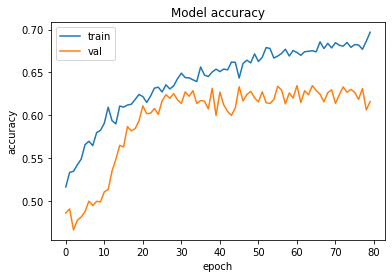

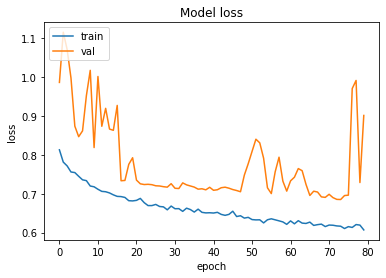

In [18]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
test_generator = generator_bands(path_test, 
                                 y_test, 
                                 eurosat_mean, 
                                 eurosat_std, 
                                 bands=selected_bands, 
                                 batch_size=BATCH_SIZE, 
                                 is_data_augmentation=True)
final_model.evaluate_generator(test_generator,30)

[1.3110512018203735, 0.53541666]

# Result analysis
## RGB model

In [22]:
history_13bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation3_13bands_1', 'band_variation3_13bands_1.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation3_RGB_SWIR_1', 'band_variation3_RGB_SWIR_1.npy'),allow_pickle='TRUE').item()
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation3_highres_1', 'band_variation3_highres_1.npy'),allow_pickle='TRUE').item()

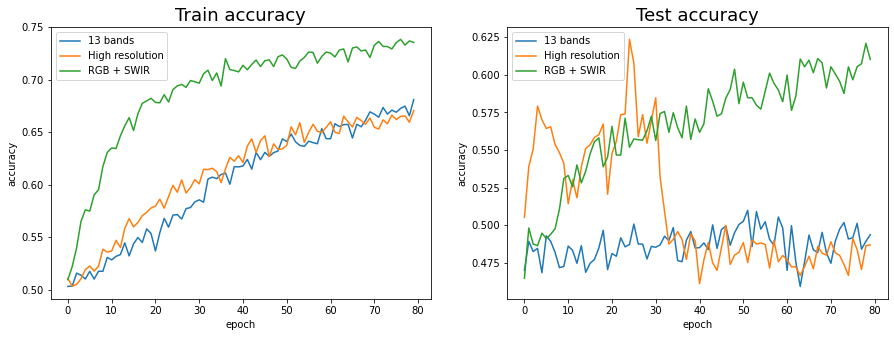

In [23]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['accuracy'])
axes[0].plot(history_highres_bands['accuracy'])
axes[0].plot(history_rgb_swir_bands['accuracy'])
axes[0].set_title('Train accuracy', fontsize=18)
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR'], loc='upper left')

axes[1].plot(history_13bands['val_accuracy'])
axes[1].plot(history_highres_bands['val_accuracy'])
axes[1].plot(history_rgb_swir_bands['val_accuracy'])
axes[1].set_title('Test accuracy', fontsize=18)
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR'], loc='upper left')

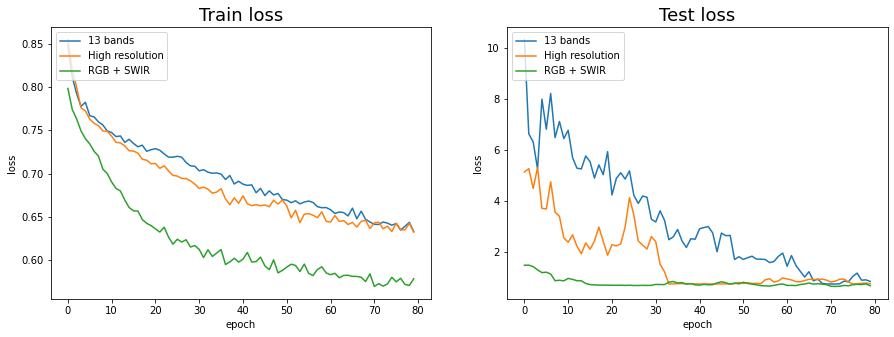

In [24]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_13bands['loss'])
axes[0].plot(history_highres_bands['loss'])
axes[0].plot(history_rgb_swir_bands['loss'])
axes[0].set_title('Train loss', fontsize=18)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands', 'High resolution', 'RGB + SWIR'], loc='upper left')

axes[1].plot(history_13bands['val_loss'])
axes[1].plot(history_highres_bands['val_loss'])
axes[1].plot(history_rgb_swir_bands['val_loss'])
axes[1].set_title('Test loss', fontsize=18)
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands', 'High resolution', 'RGB + SWIR'], loc='upper left')

## 13 bands model

In [25]:
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation13_highres', 'band_variation13_highres.npy'),allow_pickle='TRUE').item()
history_rgb_swir_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation13_RGB_SWR', 'band_variation13_RGB_SWR.npy'),allow_pickle='TRUE').item()

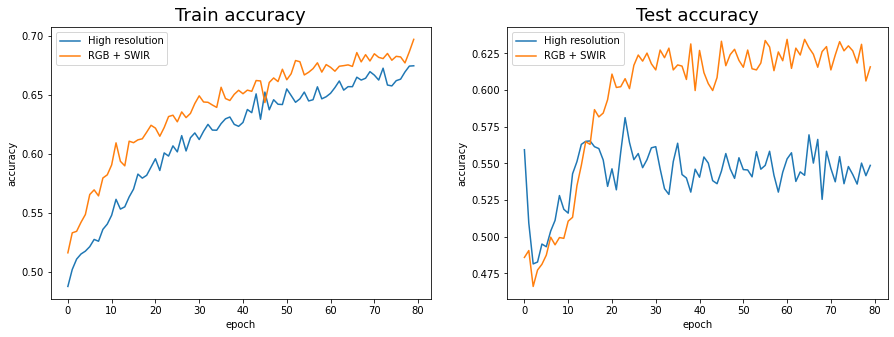

In [26]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_highres_bands['accuracy'])
axes[0].plot(history_rgb_swir_bands['accuracy'])
axes[0].set_title('Train accuracy', fontsize=18)
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['High resolution','RGB + SWIR'], loc='upper left')

axes[1].plot(history_highres_bands['val_accuracy'])
axes[1].plot(history_rgb_swir_bands['val_accuracy'])
axes[1].set_title('Test accuracy', fontsize=18)
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['High resolution','RGB + SWIR'], loc='upper left')

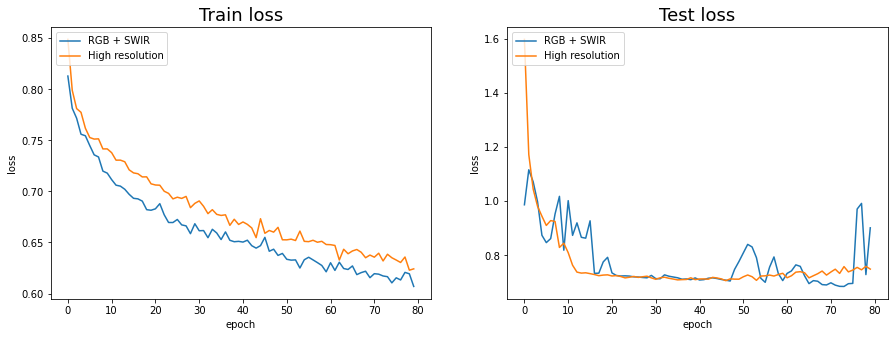

In [27]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_rgb_swir_bands['loss'])
axes[0].plot(history_highres_bands['loss'])
axes[0].set_title('Train loss', fontsize=18)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['RGB + SWIR', 'High resolution'], loc='upper left')

axes[1].plot(history_rgb_swir_bands['val_loss'])
axes[1].plot(history_highres_bands['val_loss'])
axes[1].set_title('Test loss', fontsize=18)
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['RGB + SWIR', 'High resolution'], loc='upper left')

## Comparison with original model

In [29]:
history_transfer_learning = np.load(os.path.join('saved_models','transfer_learning', 'Coffee','transfer_learning3', 'transfer_learning3.npy'),allow_pickle='TRUE').item()
history_highres_bands = np.load(os.path.join(SAVED_MODELS_PATH, 'Coffee','band_variation3_highres_1', 'band_variation3_highres_1.npy'),allow_pickle='TRUE').item()

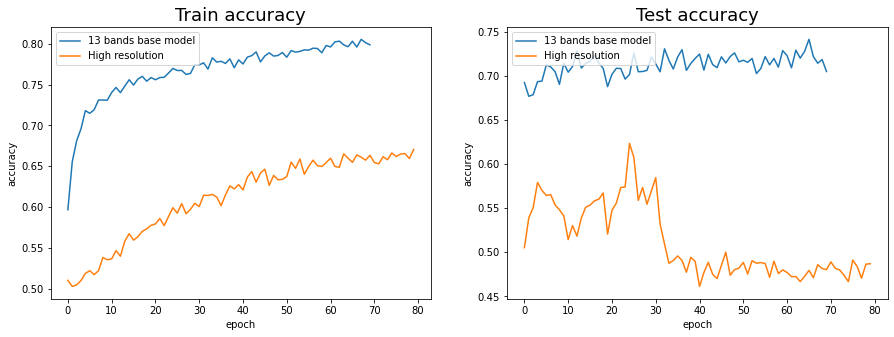

In [30]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_transfer_learning['accuracy'])
axes[0].plot(history_highres_bands['accuracy'])
axes[0].set_title('Train accuracy', fontsize=18)
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands base model','High resolution'], loc='upper left')

axes[1].plot(history_transfer_learning['val_accuracy'])
axes[1].plot(history_highres_bands['val_accuracy'])
axes[1].set_title('Test accuracy', fontsize=18)
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands base model','High resolution'], loc='upper left')

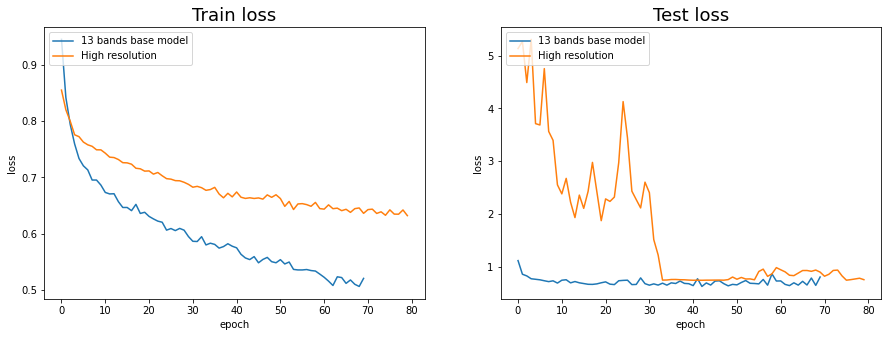

In [37]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history_transfer_learning['loss'])
axes[0].plot(history_highres_bands['loss'])
axes[0].set_title('Train loss', fontsize=18)
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['13 bands base model','High resolution'], loc='upper left')

axes[1].plot(history_transfer_learning['val_loss'])
axes[1].plot(history_highres_bands['val_loss'])
axes[1].set_title('Test loss', fontsize=18)
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['13 bands base model','High resolution'], loc='upper left')